# Simulating Bell Inequality using Momentum Mixing

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [2]:
!python -V

Python 3.10.8


In [130]:
import pickle
import bz2
import gzip
import lzma

In [70]:
from multiprocessing import Pool

In [3]:
from joblib import Parallel, delayed

In [4]:
from tqdm.notebook import tqdm

In [5]:
# from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [6]:
import pyfftw
nthreads=2

In [7]:
# import tensorflow.experimental.numpy as tnp
# tnp.experimental_enable_numpy_behavior()

In [8]:
nx = 2000+1
nz = 2000+1
xmax = 60 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-4 # Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)

print(round(nx*nz/1000/1000,3),"million grid points")
print(round((nx*nz)*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

zmax = 60.0
(dx,dz) = (0.06, 0.06)
rotate phase = 0.22051319444444445j
pxmax = 3328.585892726259
pzmax = 3328.585892726259
4.004 million grid points
0.07 minutes/grid_op (for 1μs/element_op)


In [9]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 2*pi / wavelength
dopd = 60.1025 # 1/ms Doppler detuning (?)
p = 2*hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

k = 4.102384984449092 1/µm
p = 521.0668902307921 u*µm/ms
v = 65.13336127884901 µm/ms


In [214]:
a4 = 0.007512 # scattering length 
omega = 30 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
# print(round(tBraggPi,6) ,"ms")
print("tBraggPi     =", round(tBraggPi*1000,3),"µs")
print("tBraggCenter =", round(tBraggCenter*1000,3),"µs")
print("tBraggEnd    =", round(tBraggEnd*1000,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


V0 = 3810.4680000000003
tBraggPi     = 5.242 µs
tBraggCenter = 26.212 µs
tBraggEnd    = 52.423 µs


In [215]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

1.5746097329776815e-06j term infront of Bragg potential
0.45660027279369414j max(V)


In [216]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
print(round(psi.nbytes/1000/1000 ,3) , "MB of data used")
# print(psi.nbytes/1000/1000, "MB of data used")

zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

64.064 MB of data used


##### Checking parameters reasonable

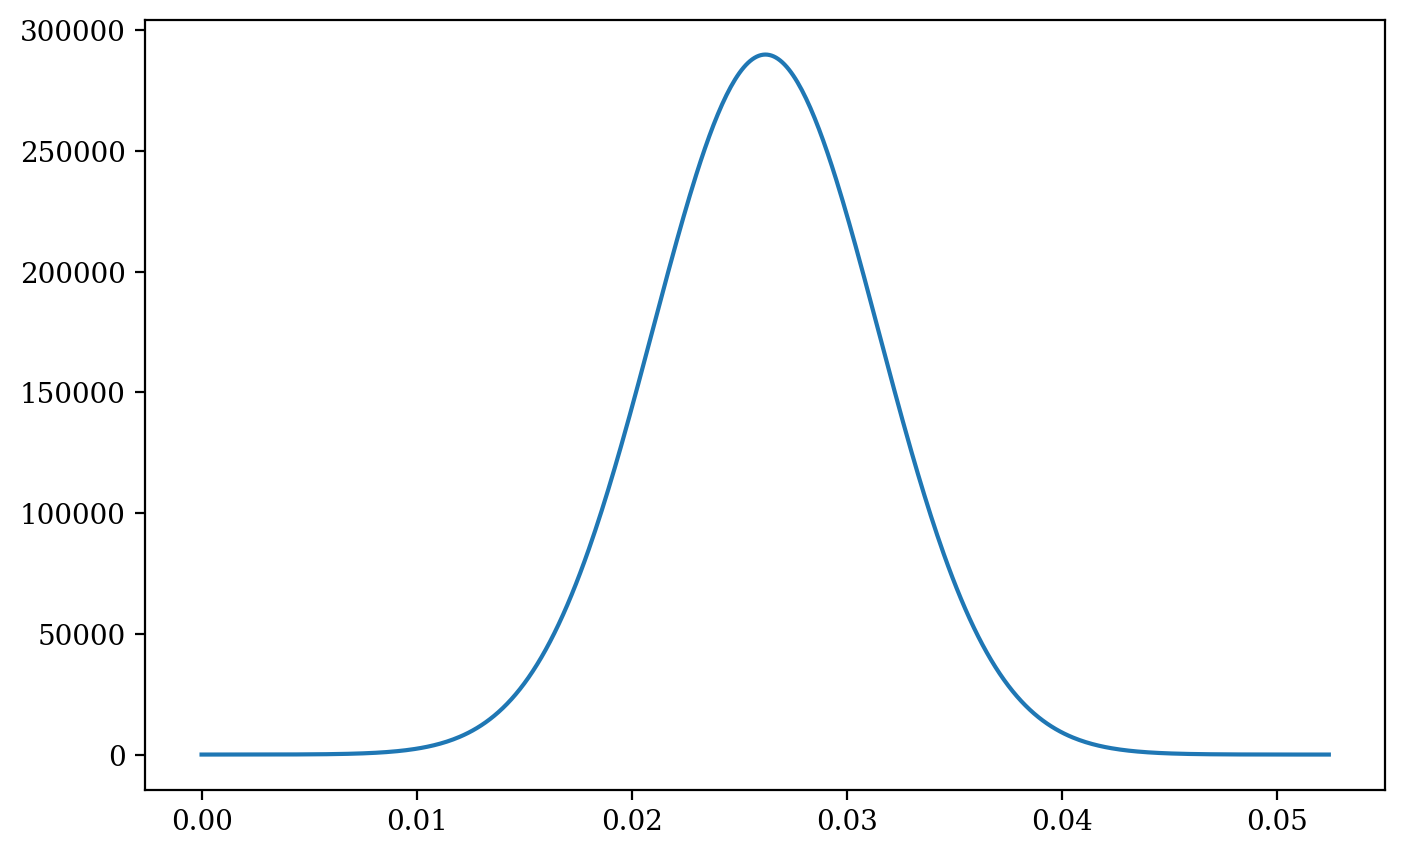

In [217]:
# smooth bragg in time
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [218]:
np.trapz(V(tbtest),tbtest) # this should be V0

3810.465788143934

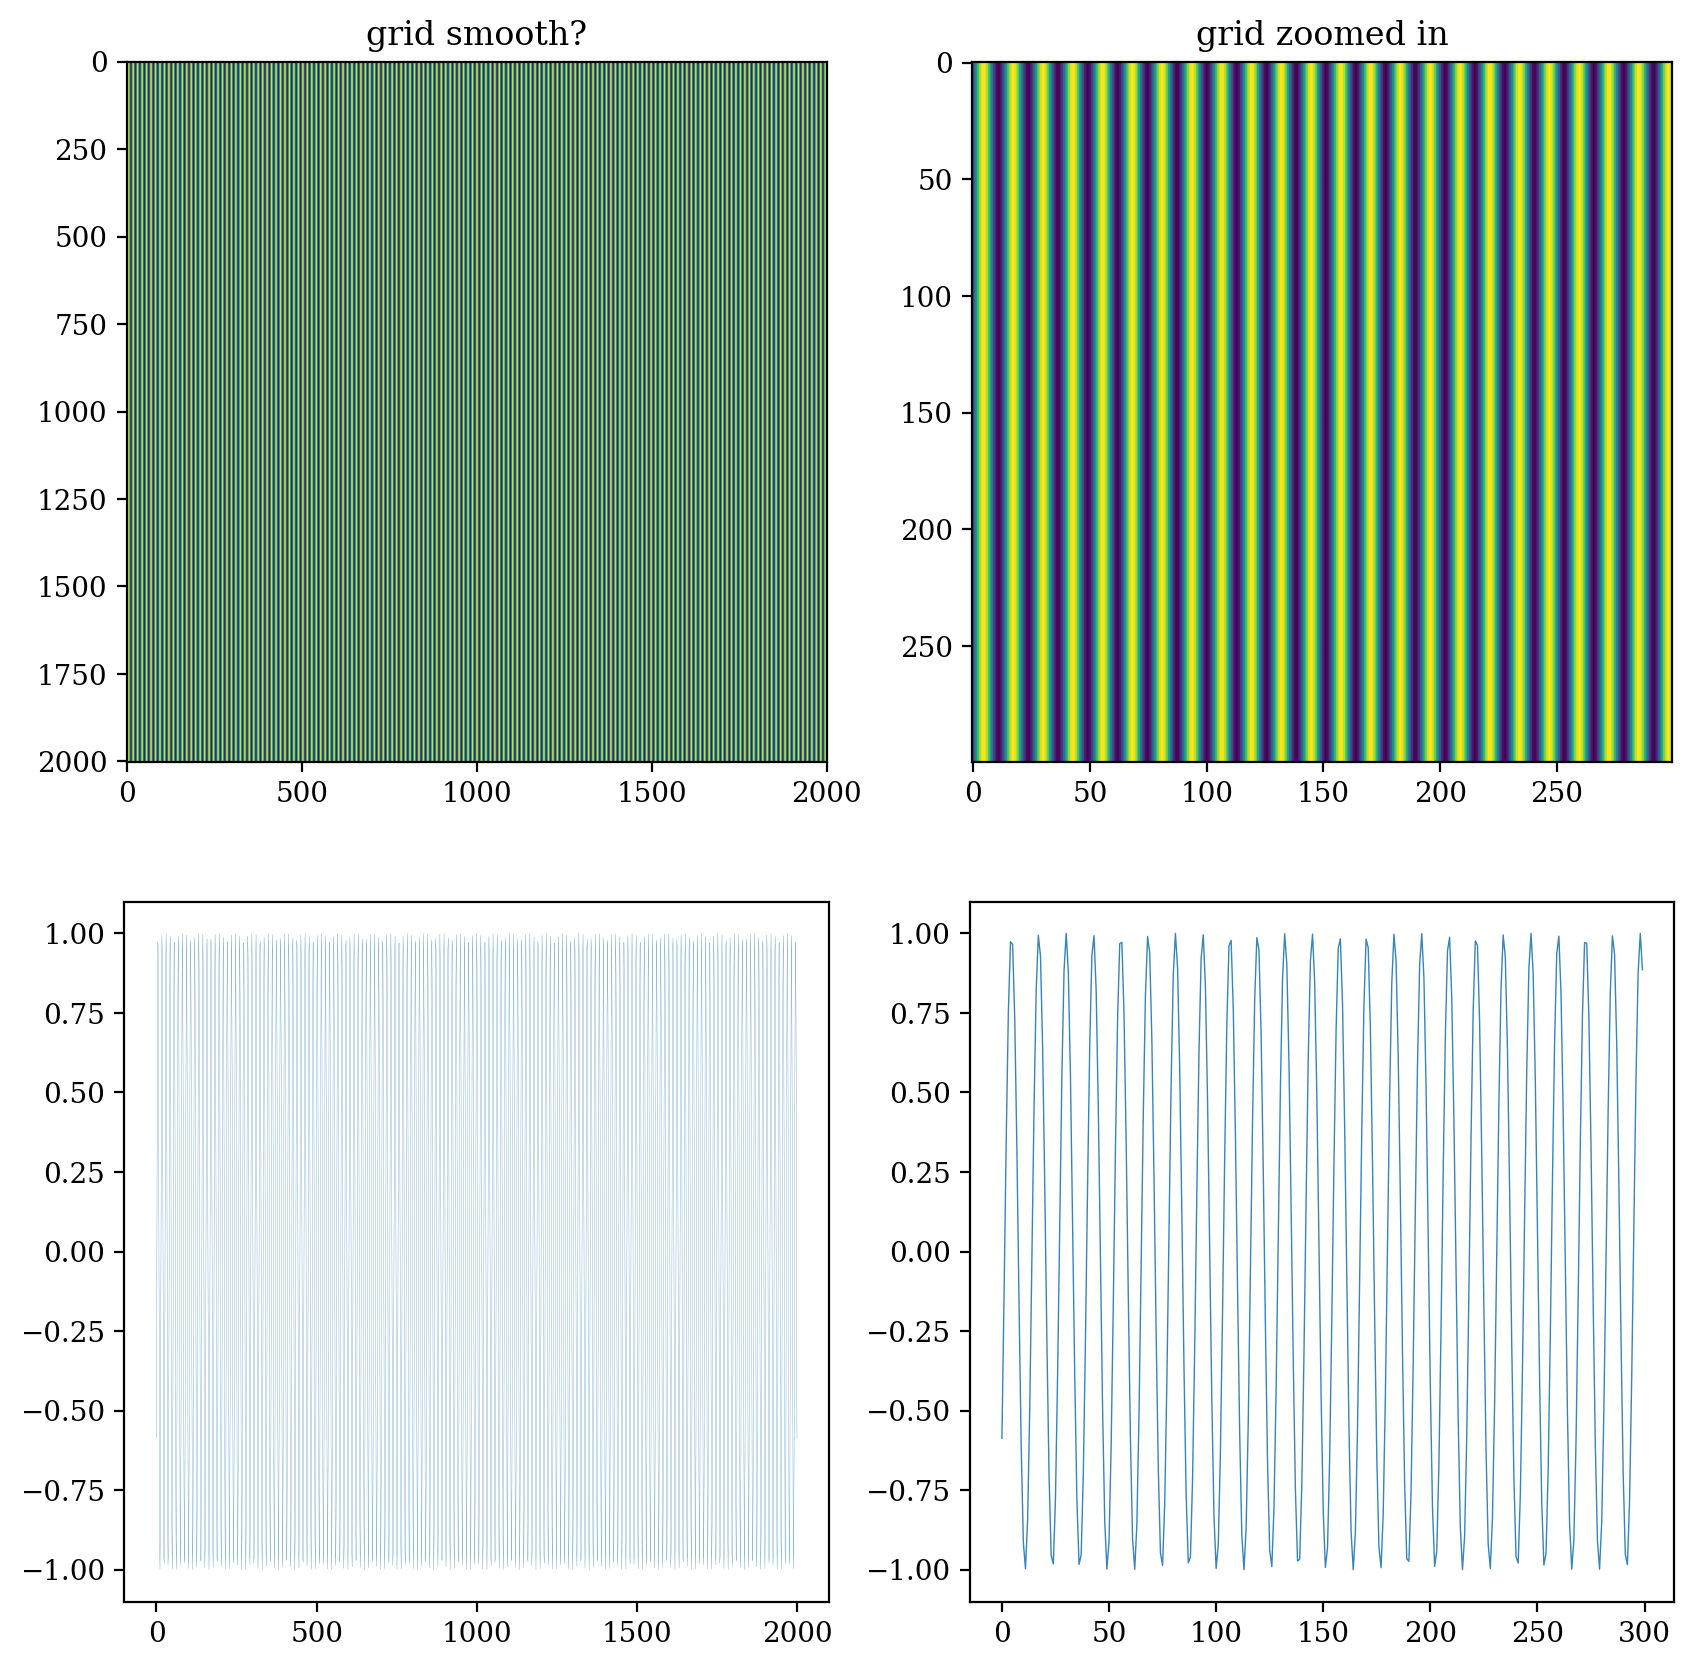

In [219]:
# vtest = np.cos(2*k*xlin)
ncrop = 300
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(cosGrid.T)
plt.title("grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosGrid[:,0],alpha=0.9,linewidth=0.1)

plt.subplot(2,2,4)
plt.plot(cosGrid[:ncrop,0],alpha=0.9,linewidth=0.5)
plt.show()

#### More backend stuff

In [220]:
def plot_psi(psi):
    plt.figure(figsize=(12,4))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (µm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [221]:
def plot_mom(psi):
    plt.figure(figsize=(12,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])/(hb*k)
#     psifft = np.fft.fftshift(np.fft.fft2(psi))
    psifft = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    psiAbsSqUnNorm = np.abs(psifft)**2
    swnf = sqrt(np.sum(psiAbsSqUnNorm)*dpx*dpz)
    psiAbsSq = psiAbsSqUnNorm / swnf
#     print(np.sum(psiAbsSq)*dpx*dpz)
#     plotdata = np.flipud(psiAbsSq.T)
    plotdata = (psiAbsSq.T)
    
    plt.subplot(1,3,1)
    plt.imshow(plotdata,extent=extent) 
    plt.ylabel("$p_z$ (u*µm/ms)")
    
    plt.subplot(1,3,2)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/20)
    nz2 = int((nz-1)/20)
    plotdata = (psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,extent=extent*0.1) 
    
    plt.subplot(1,3,3)
#     nx3 = int((nx-1)/200)
#     nz3 = int((nz-1)/200)
#     plotdata = np.flipud(psiAbsSq[nxm-nx3:nxm+nx3,nzm-nz3:nzm+nz3].T)
#     plt.imshow(plotdata,extent=extent*0.01) 
# #     print(nx2,nz2,nx3,nz3)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/6)
    nz2 = int((nz-1)/6)
    
    plt.plot((pxlin[nxm-nx2:nxm+nx2])/(hb*k), np.trapz(psiAbsSq,axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x= 0,color='r',alpha=0.2)
    plt.axvline(x=+2,color='r',alpha=0.2)
    plt.axvline(x=-2,color='r',alpha=0.2)
    plt.axvline(x=+4,color='r',alpha=0.2)
    plt.axvline(x=-4,color='r',alpha=0.2)
#     plt.xlabel("$p (u\cdot \mu m/ms)$")
#     plt.ylabel("$|\phi(p)|^2$")
    title = "Bragg Pulse"
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    plt.show()

In [222]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))
def psi0ringUnNorm(x,z,pr=p,mur=10,sg=sg):
#     return (pi**1.5 * sg * (1 + scipy.special.erf(mur/sg)))**-1 \
    return 1 \
            * np.exp(-0.5*( mur - np.sqrt(x**2 + z**2) )**2 / sg**2) \
            * np.exp(+(1j/hb) * (x**2 + z**2)**0.5 * pr)

In [223]:
# V00 = 50000
# dt=0.01
# VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
        

In [224]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
def psi0ringNp(mur=1,sg=1,pr=p):
    psi = np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0ringUnNorm(x,zlin[1:-1],pr,mur,sg)
    norm = np.sum(np.abs(psi)**2)*dx*dz
    psi *= 1/sqrt(norm)
    return psi

Super weird normalisation factor, swnf = 55.42101053490277
0.9999999999999998 |phi|**2 normalisation check
1.0000000000000009 |psi|**2 normalisation check


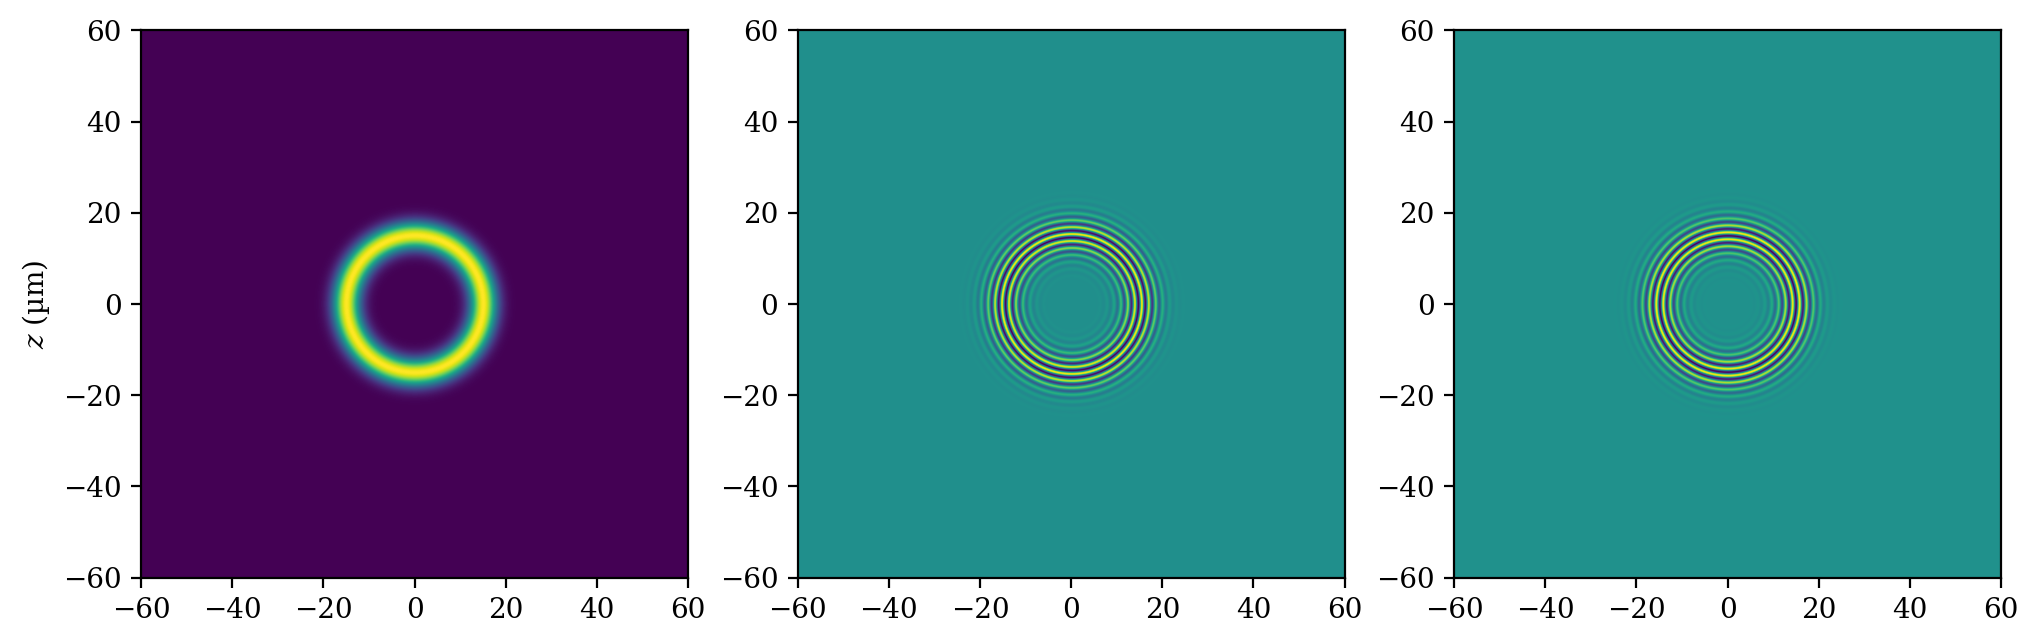

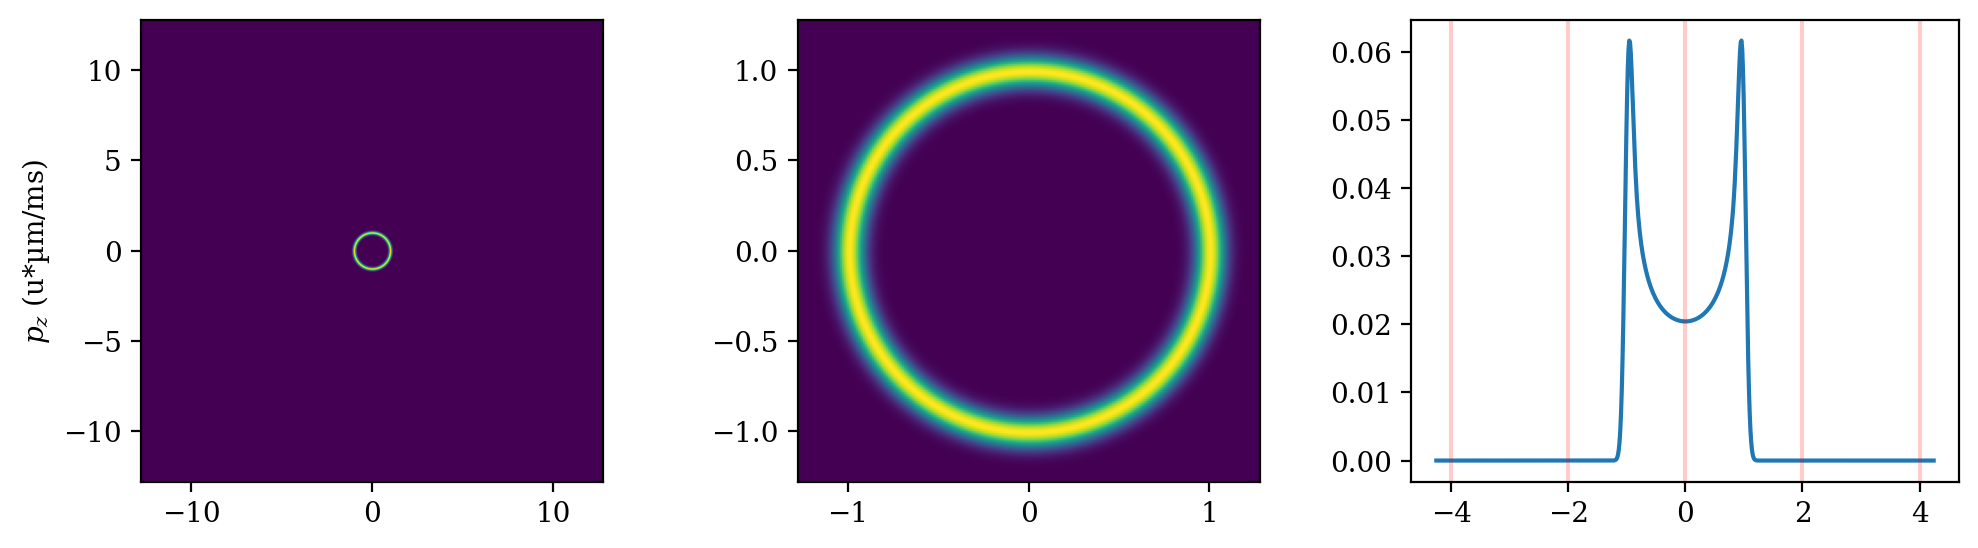

In [225]:
# psi = psi0np(5,5,0,0)
# psi = psi0np(5,5,-0.5*p,0)
# psi = psi0np(1,1,p,p)
# psi = psi0np(1,1,0,0)

def phiAndSWNF(psi):
    phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
    # superWeirdNormalisationFactorSq = np.trapz(np.trapz(np.abs(phiUN)**2, pxlin, axis=0), pzlin)
    superWeirdNormalisationFactorSq = np.sum(np.abs(phiUN)**2)*dpx*dpz
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return (swnf, phi)
    
psi = psi0ringNp(15,3,0.5*p)
(swnf, phi) = phiAndSWNF(psi)

t = 0

print("Super weird normalisation factor, swnf =",swnf)
print(np.sum(np.abs(phi)**2)*dpx*dpz, "|phi|**2 normalisation check")
print(np.sum(np.abs(psi)**2)*dx*dz,   "|psi|**2 normalisation check")
plot_psi(psi)
plot_mom(psi)

In [226]:
def toMomentum(psi, swnf):
    return np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swnf
def toPosition(phi, swnf):
    return pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swnf)),threads=nthreads,norm='ortho')


In [431]:
def plotNow(t, psi):
        print("time =", round(t*1000,4), "µs")
        print(np.sum(np.abs(psi)**2)*dx*dz,"|psi|^2")
        print(np.sum(np.abs(phi)**2)*dpx*dpz,"|phi|^2")
        plot_psi(psi)
        plot_mom(psi)
        
def numericalEvolve(
        t_init, 
        psi, 
        t_final, 
        tauPi  = tBraggPi, 
        tauMid = tBraggPi*5, 
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True,
    ):
    assert (print_every_t > dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    (swnf, phi) = phiAndSWNF(psi)
    t = t_init
    
#     tauMid = tauPi * 5
#     tauEnd = tauPi * 10
    
    def VB(t):
#         return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        cosGrid = np.cos(2*k*xgrid + dopd*(t-tBraggCenter))
        VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * VB(t) * cosGrid )
        psi *= VxExpGrid
        phi = toMomentum(psi,swnf)
        phi *= expPGrid
        psi = toPosition(phi,swnf)
        psi *= VxExpGrid
        
        if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
            plotNow(t,psi)
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        plotNow(t,psi)
    return (t,psi,phi)

In [228]:
(tBraggCenter,tBraggEnd,tBraggPi)

(0.02621169790113246, 0.05242339580226492, 0.005242339580226492)

In [229]:
# short test run
_ = numericalEvolve(0, psi0np(5,5,0.5*p,0), 2*dt,progress_bar=False,final_plot=False)

In [230]:
# (t,psi,phi) = numericalEvolve(0, psi0ringNp(15,3,0.5*p), tBraggEnd, tBraggPi, tBraggCenter)
# (backup_t,backup_psi,backup_phi) = (t,psi,phi)

In [231]:
# (t,psi,phi) = (backup_t,backup_psi,backup_phi)
# plotNow(t,psi)

In [232]:
# pure_x_t = numericalEvolve(0, psi0np(5,5,0.5*p,0), tBraggEnd, tBraggPi, tBraggCenter)
# pure_z_t = numericalEvolve(0, psi0np(5,5,0,0.5*p), tBraggEnd, tBraggPi, tBraggCenter)

In [312]:
tPiTest = np.arange(0.005+dt,0,-dt)
# tPiTest = np.arange(dt,3*dt,dt)
def scanTauPiInnerEval(tPi, logging=True):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    return numericalEvolve(0, psi0np(5,5,0.5*p,0), 
                           tauEnd, tauPi, tauMid,
                           final_plot=logging,progress_bar=logging)


In [313]:
# tPiOutput = {}
# for tPi in tqdm(tPiTest):
#     tPiOutput[tauPi] = scanTauPiInnerEval(tPi)
# print("ALL DONE")

In [314]:
tPiOutput = Parallel(n_jobs=8)(
    delayed(lambda i: (i, scanTauPiInnerEval(i, False)[:2]) )(i) 
    for i in tqdm(tPiTest)
)
# tPiOutput.append(0, (0,(0,psi0np(5,5,0.5*p,0))))

  0%|          | 0/51 [00:00<?, ?it/s]

In [315]:
with open('output/bell_simu_proj/tPiOutput.pkl', 'wb') as file:
    pickle.dump(tPiOutput, file)

In [316]:
# with gzip.open('output/bell_simu_proj/tPiOutput_gzip.pkl', 'wb') as file:
#     pickle.dump(tPiOutput, file)

In [317]:
# with lzma.open('output/bell_simu_proj/tPiOutput_lzma.pkl', 'wb') as file:
#     pickle.dump(tPiOutput, file)

In [318]:
# with bz2.BZ2File('output/bell_simu_proj/tPiOutput_BZ2.pkl', 'wb') as file:
#     pickle.dump(tPiOutput, file)

In [319]:
# with open('output/bell_simu_proj/tPiOutput.pkl', 'rb') as file:
#     tPiOutputLoaded = pickle.load(file)
# # tPiOutput = tPiOutputLoaded

In [320]:
# with bz2.BZ2File('output/bell_simu_proj/tPiOutput_BZ2.pkl', 'rb') as file:
#     tPiOutputLoadedBZ2 = pickle.load(file)
# # tPiOutput = tPiOutputLoaded

0.050000000000000405 0.005


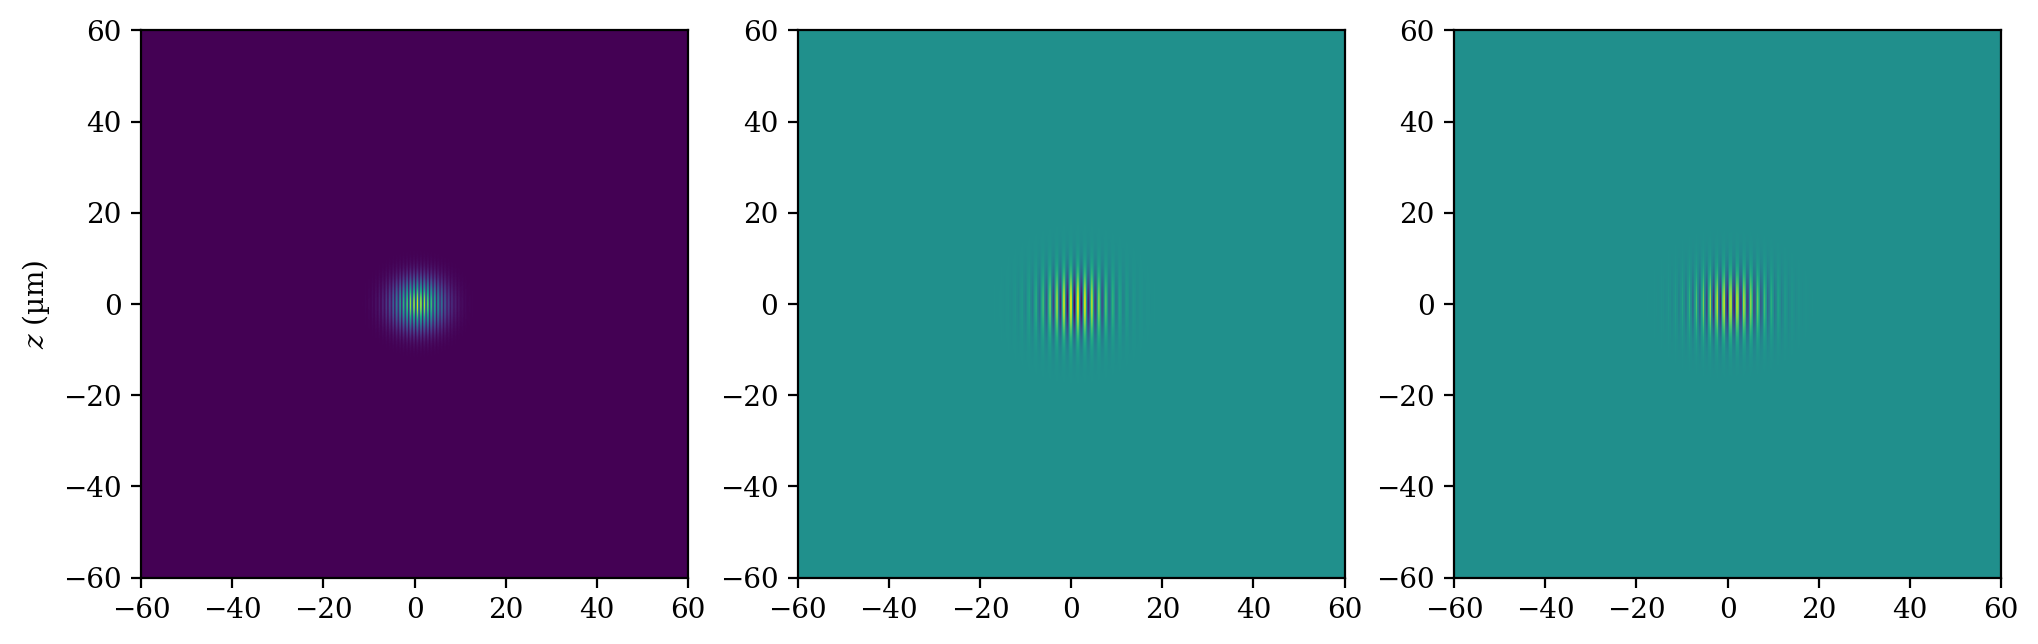

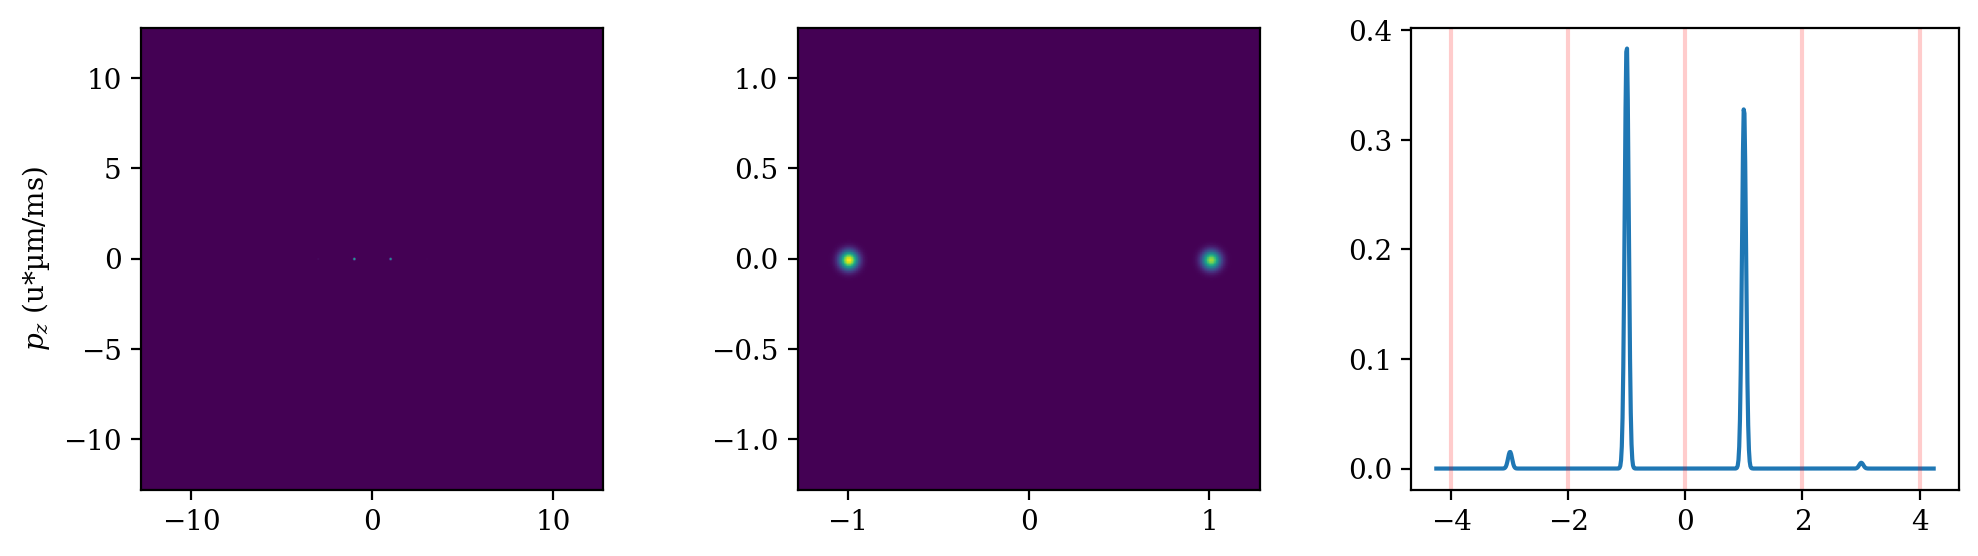

In [390]:
print(tPiOutput[1][1][0], tPiOutput[1][0])
plot_psi(tPiOutput[1][1][1])
plot_mom(tPiOutput[1][1][1])

In [391]:
phiDensityGrid = np.zeros((len(tPiOutput), pxlin.size))
hbar_k_transfers = np.arange(-6,6+1)
phiDensityGrid_hbark = np.zeros((len(tPiOutput),len(hbar_k_transfers)))
cut_p_width = 0.2

pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
for (j, hbar_k) in enumerate(hbar_k_transfers):
    pzlinIndexSet[j] = abs(pzlin/(hb*k) - hbar_k) <= cut_p_width
    # print(i,hbar_k)

for i in tqdm(range(len(tPiOutput))):
    item = tPiOutput[i]
#     print("tauPi =", round(item[0],5),"\t tauEnd =", round(item[1][0],5))
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
#     plt.plot(pxlin, phiX)
#     plt.show()
    phiDensityGrid[i] = phiX
#     break
    
    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])

  0%|          | 0/51 [00:00<?, ?it/s]

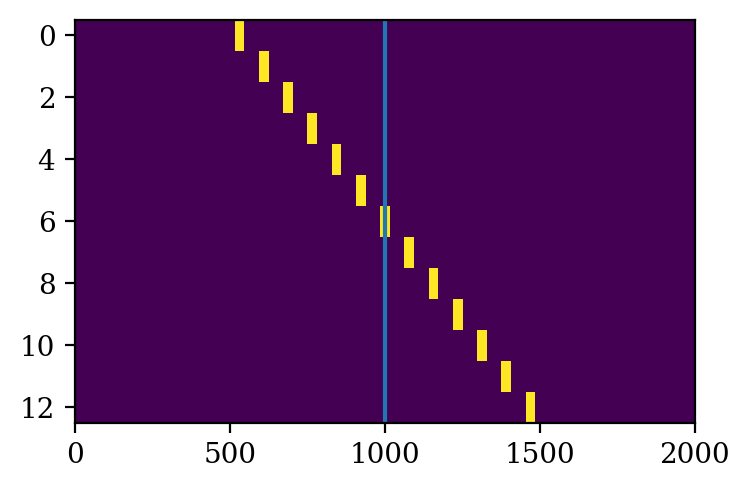

In [395]:
plt.figure(figsize=(4,4))
plt.imshow(pzlinIndexSet,interpolation='none',aspect=100)
plt.axvline(x=1001)

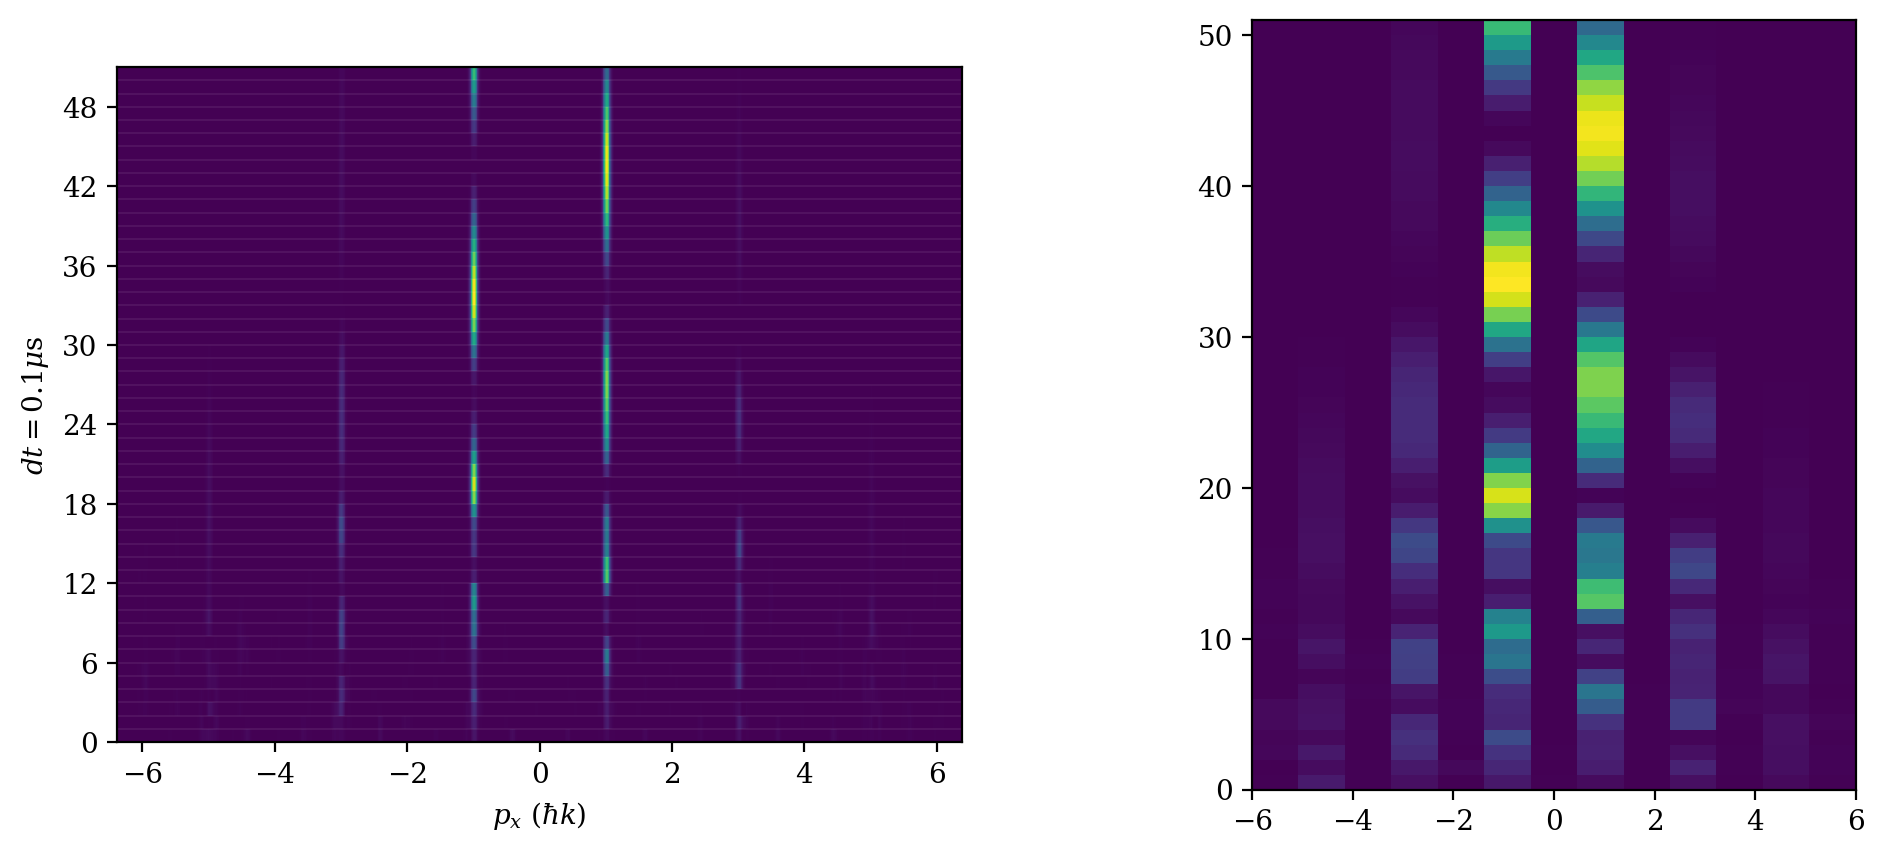

In [412]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

nxm = int((nx-1)/2)
nx2 = int((nx-1)/4)
plt.imshow(phiDensityGrid[:,nxm-nx2:nxm+nx2], 
           extent=[pxlin[nxm-nx2]/(hb*k),pxlin[nxm+nx2]/(hb*k),0,len(tPiOutput)], 
           interpolation='none',aspect=0.2)
# plt.imshow(phiDensityGrid, 
#            extent=[-pxmax/(hb*k),pxmax/(hb*k),1,len(tPiTest)+1], 
#            interpolation='none',aspect=1)
# ax = plt.gca()
for t in tPiTest:
    plt.axhline(y=t/dt,color='white',alpha=1,linewidth=0.05,linestyle='-')
ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.ylabel("$dt =$"+str(dt*1000) + "$\mu \mathrm{s}$")
plt.xlabel("$p_x \ (\hbar k)$")


plt.subplot(1,2,2)
plt.imshow(phiDensityGrid_hbark, 
           extent=[hbar_k_transfers[0],hbar_k_transfers[-1],0,len(tPiOutput)], 
           interpolation='none',aspect=0.3)

plt.show()

In [415]:
hbar_k_transfers[5]

-1

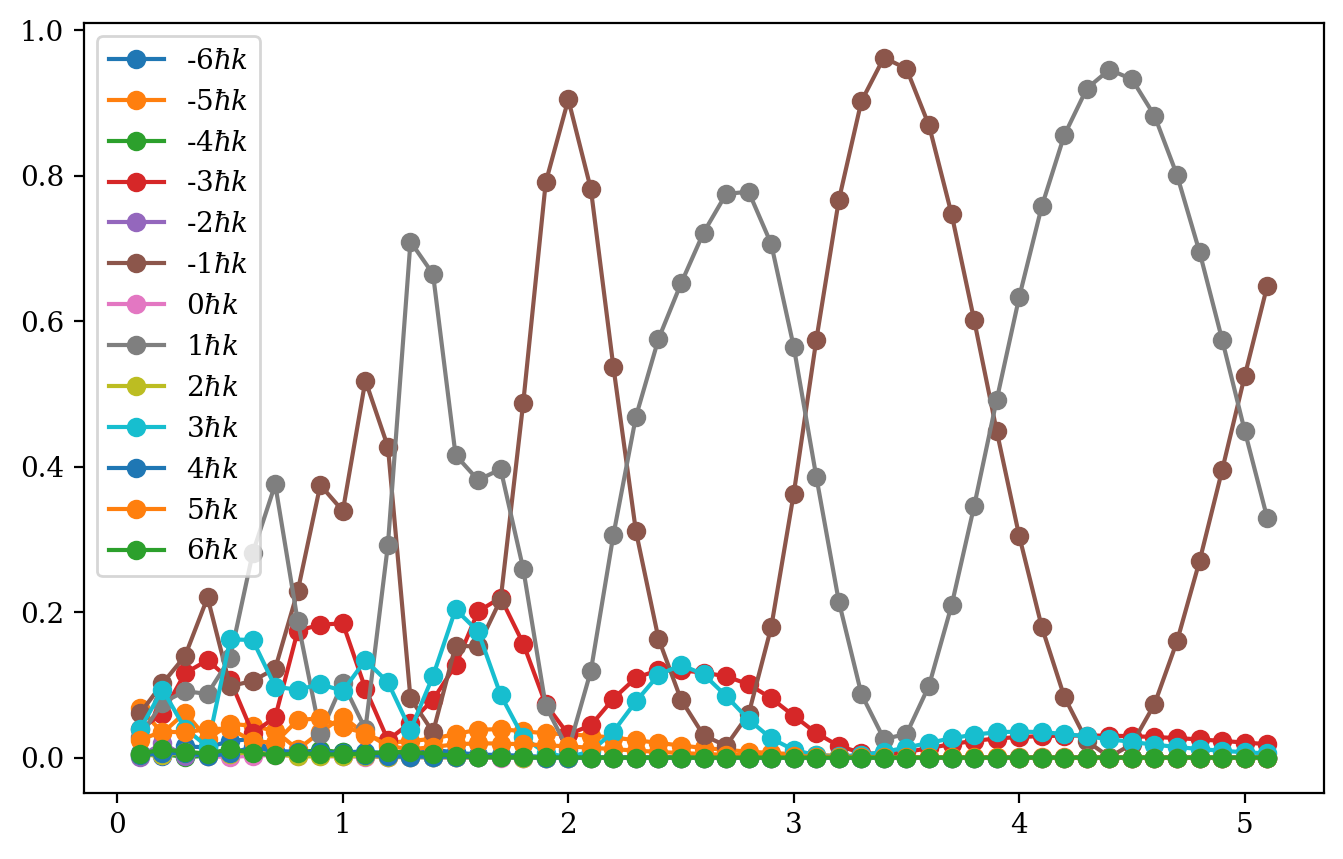

In [430]:
for (i, hbar_k) in enumerate(hbar_k_transfers):
    plt.plot(tPiTest*1000, phiDensityGrid_hbark[:,i],
             'o-',label=str(hbar_k)+"$\hbar k$")

plt.legend()
plt.

In [146]:
def plot_mom_xline(phi, cutP=1):
    plt.figure(figsize=(11,4))
    pspace = np.fft.fftfreq(nx)
    psiAbsSqUnNorm = np.abs(phi)**2
    swnf = sqrt(np.sum(psiAbsSqUnNorm)*dpx*dpz)
    psiAbsSq = psiAbsSqUnNorm / swnf
    plotdata = (psiAbsSq.T)
    
    pzlinIndex = abs(pzlin/(hb*k)) <= cutP
    
    plt.subplot(1,2,1)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/6)
    nz2 = int((nz-1)/6)
    extent = np.array([pxlin[nxm-nx2],pxlin[nxm+nx2],pzlin[nzm-nz2],pzlin[nzm+nz2]])/(hb*k)
    plotdata = (psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,extent=extent) 
    ax = plt.gca()
#     print((extent[0],extent[2]),(extent[1]-extent[0]))
#     ax.add_patch(matplotlib.patches.Rectangle((extent[0],extent[2]),(extent[1]-extent[0]),2))
    ax.add_patch(matplotlib.patches.Rectangle((extent[0],-cutP),(extent[1]-extent[0]),2*cutP,
                                              color='white',alpha=0.15))
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$p_z \ (\hbar k)$")
    plt.title("$|\phi (p)|^2$ Momentum Distribution")
    
    plt.subplot(1,2,2)
    plt.plot((pxlin[nxm-nx2:nxm+nx2])/(hb*k), np.trapz(psiAbsSq[:,pzlinIndex],axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x= 0,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=+2,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=-2,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=+4,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.axvline(x=-4,color='r',alpha=0.2,linewidth=1,linestyle='--')
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$|\phi(p_x)|^2$")
    plt.title("Integrated $p_z$ over $\pm$"+str(round(cutP,2))+" ($\hbar k$)")
    title = "Bragg Pulse"
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    plt.show()

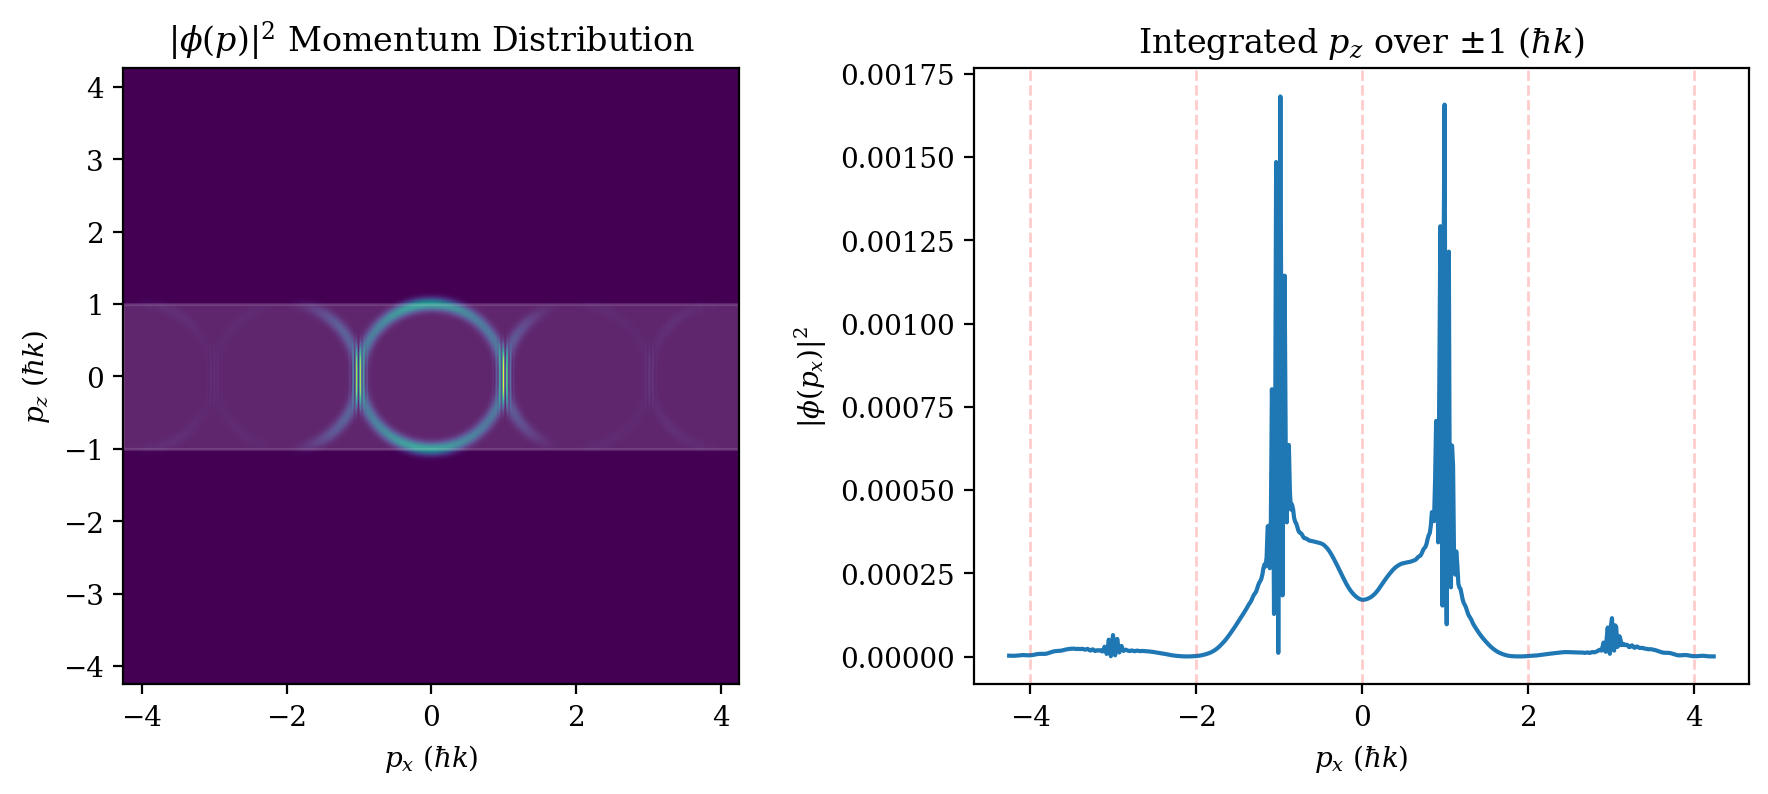

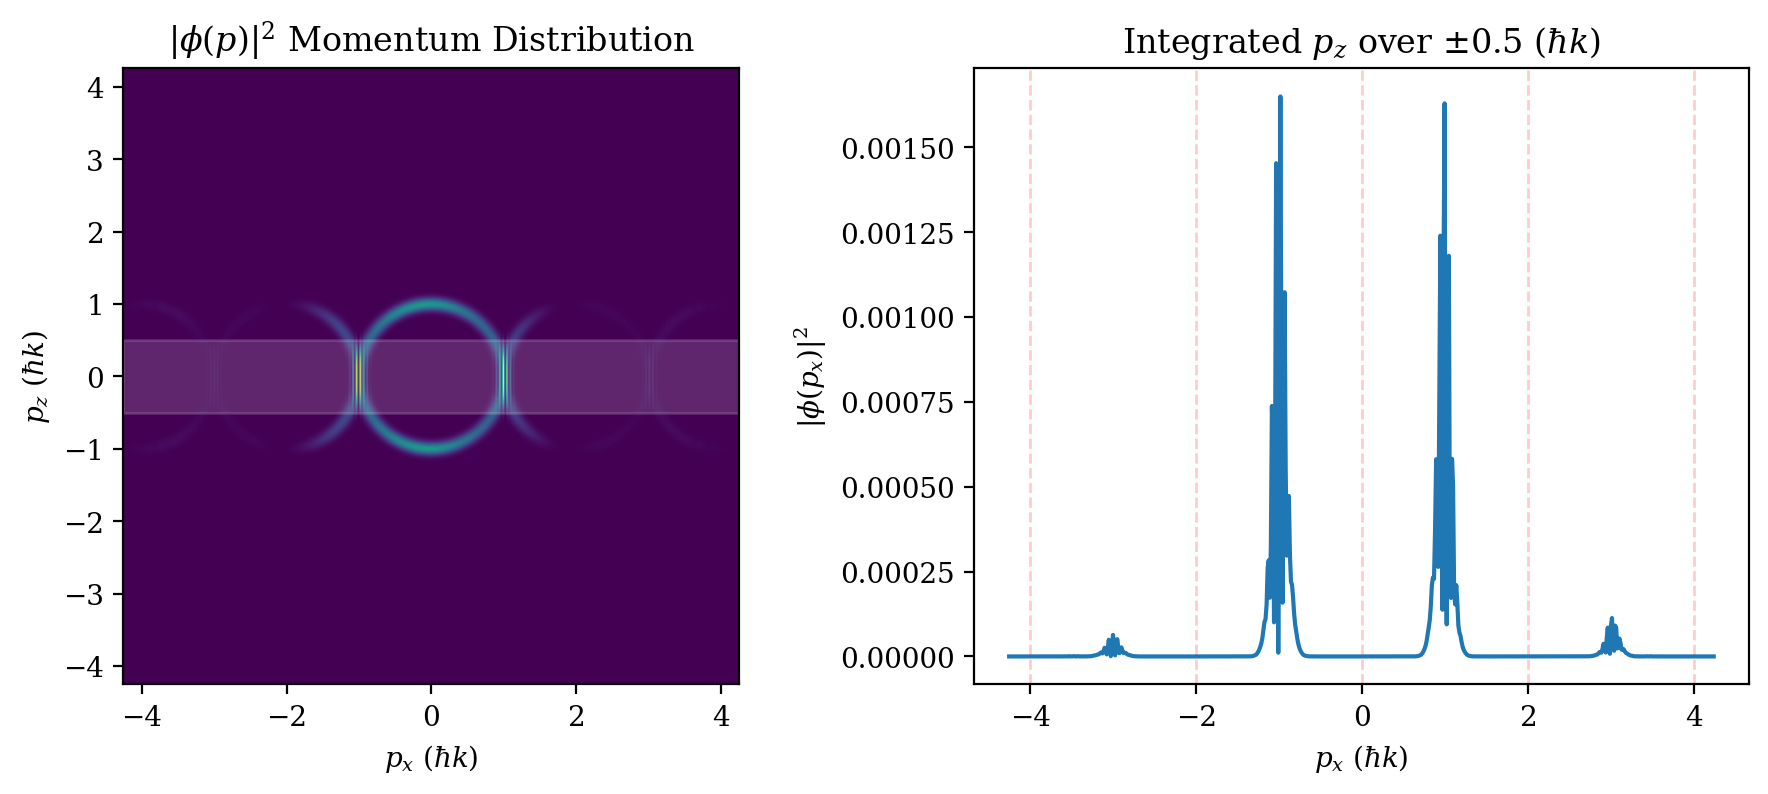

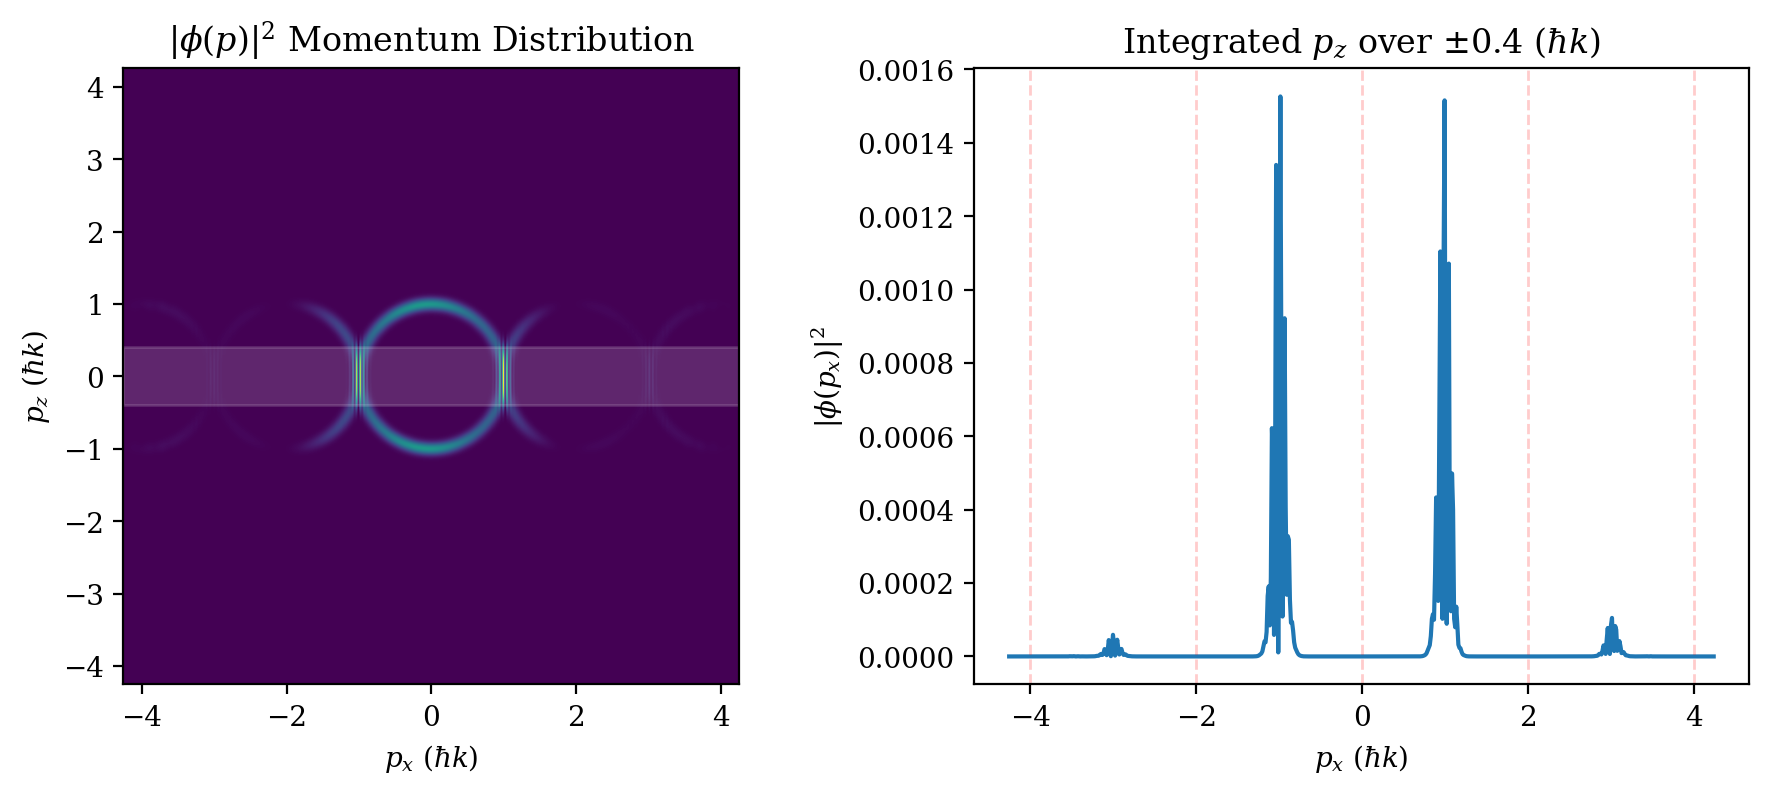

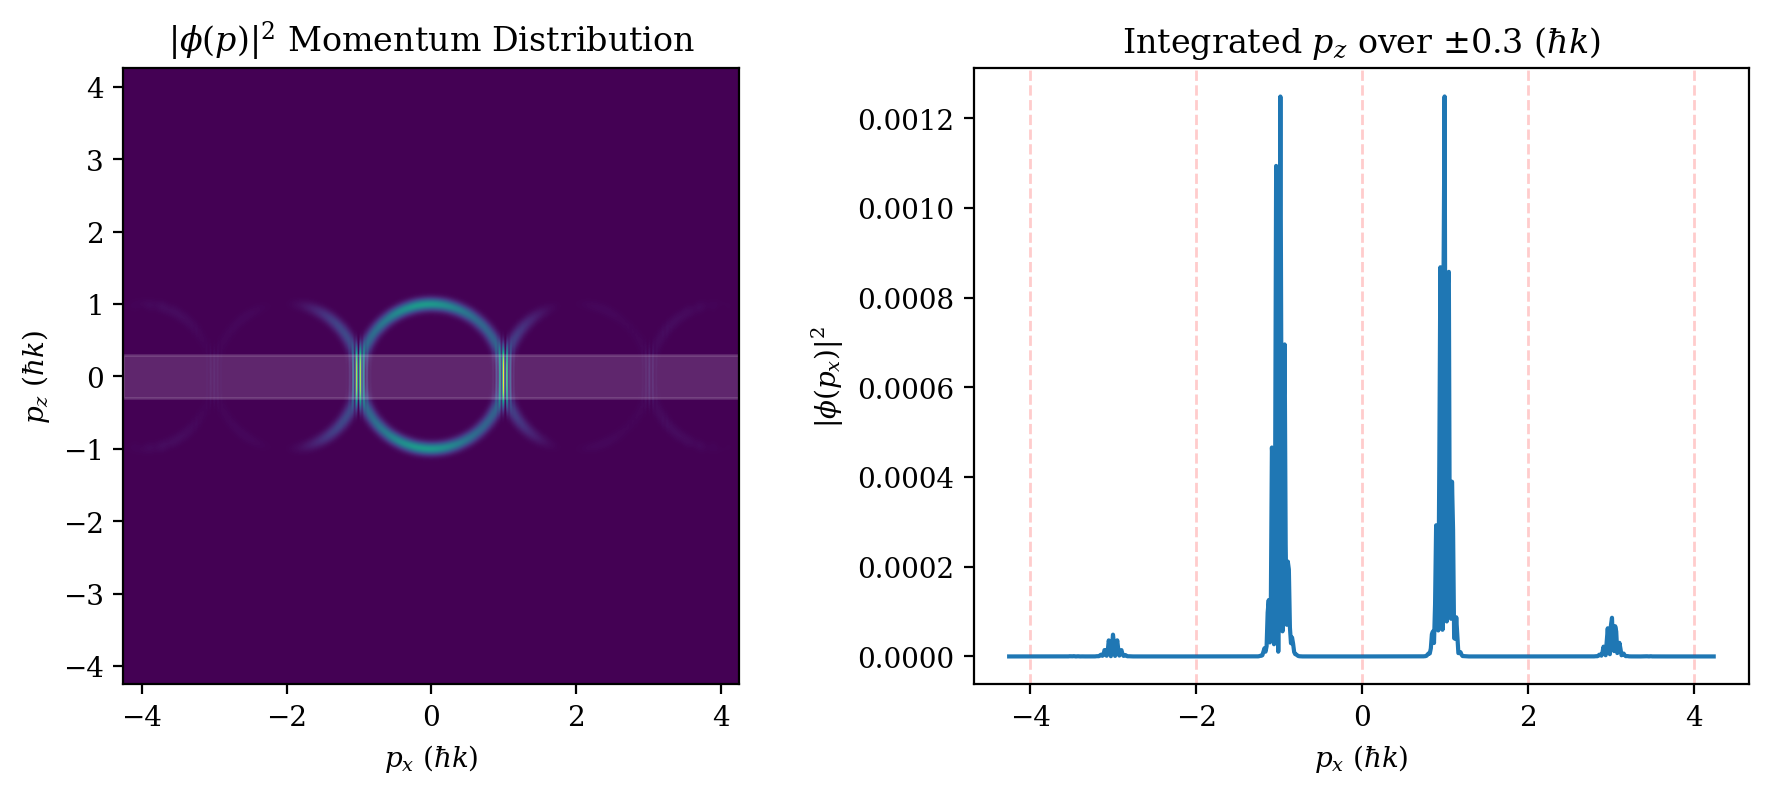

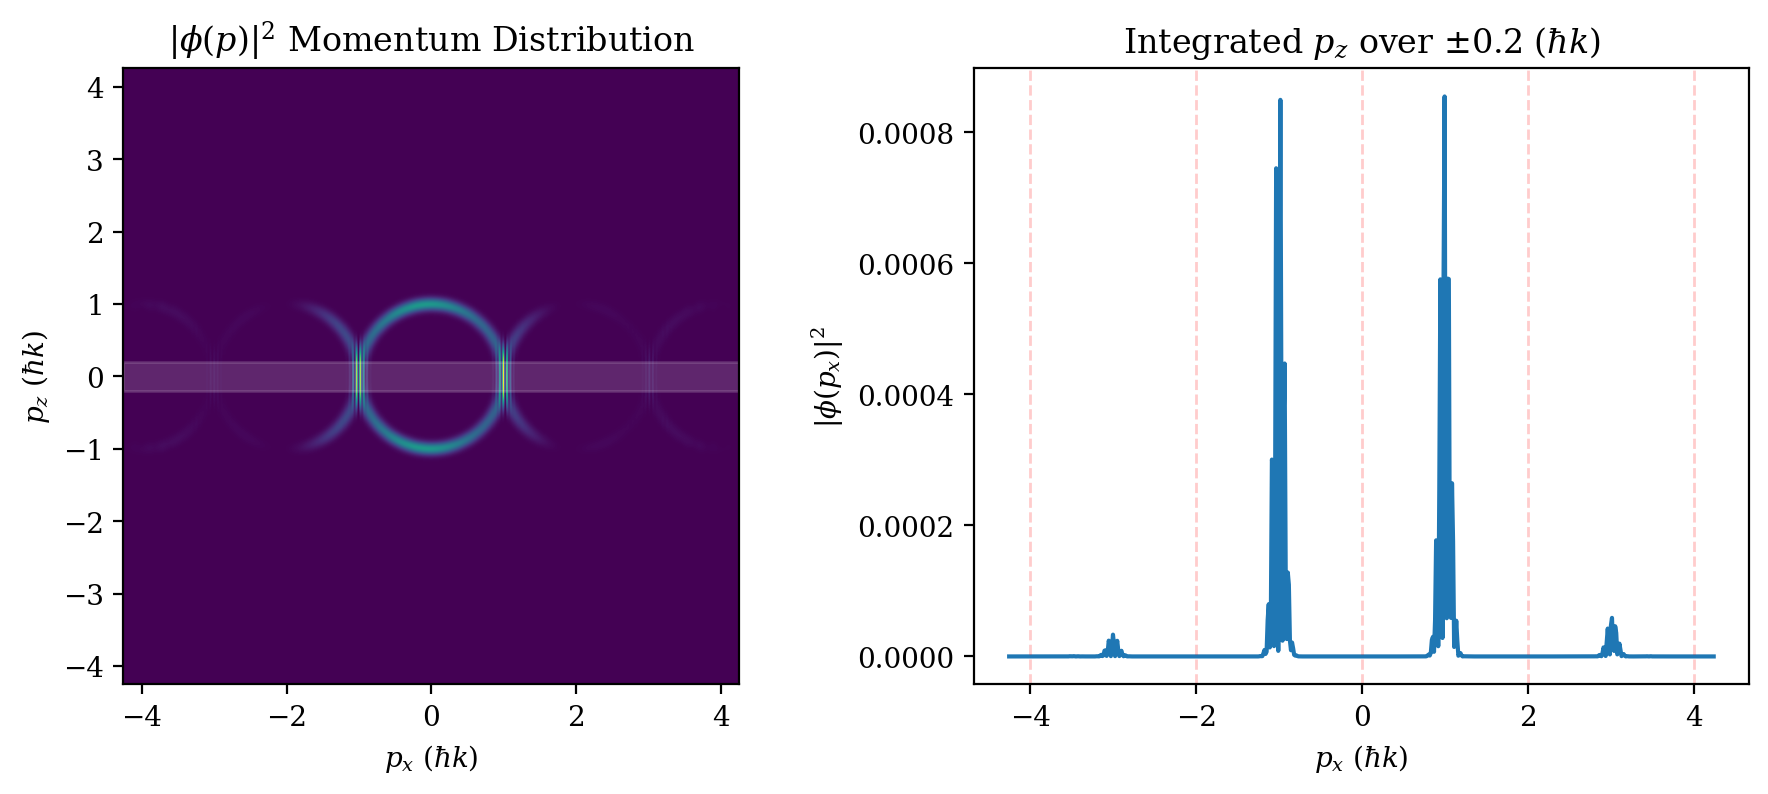

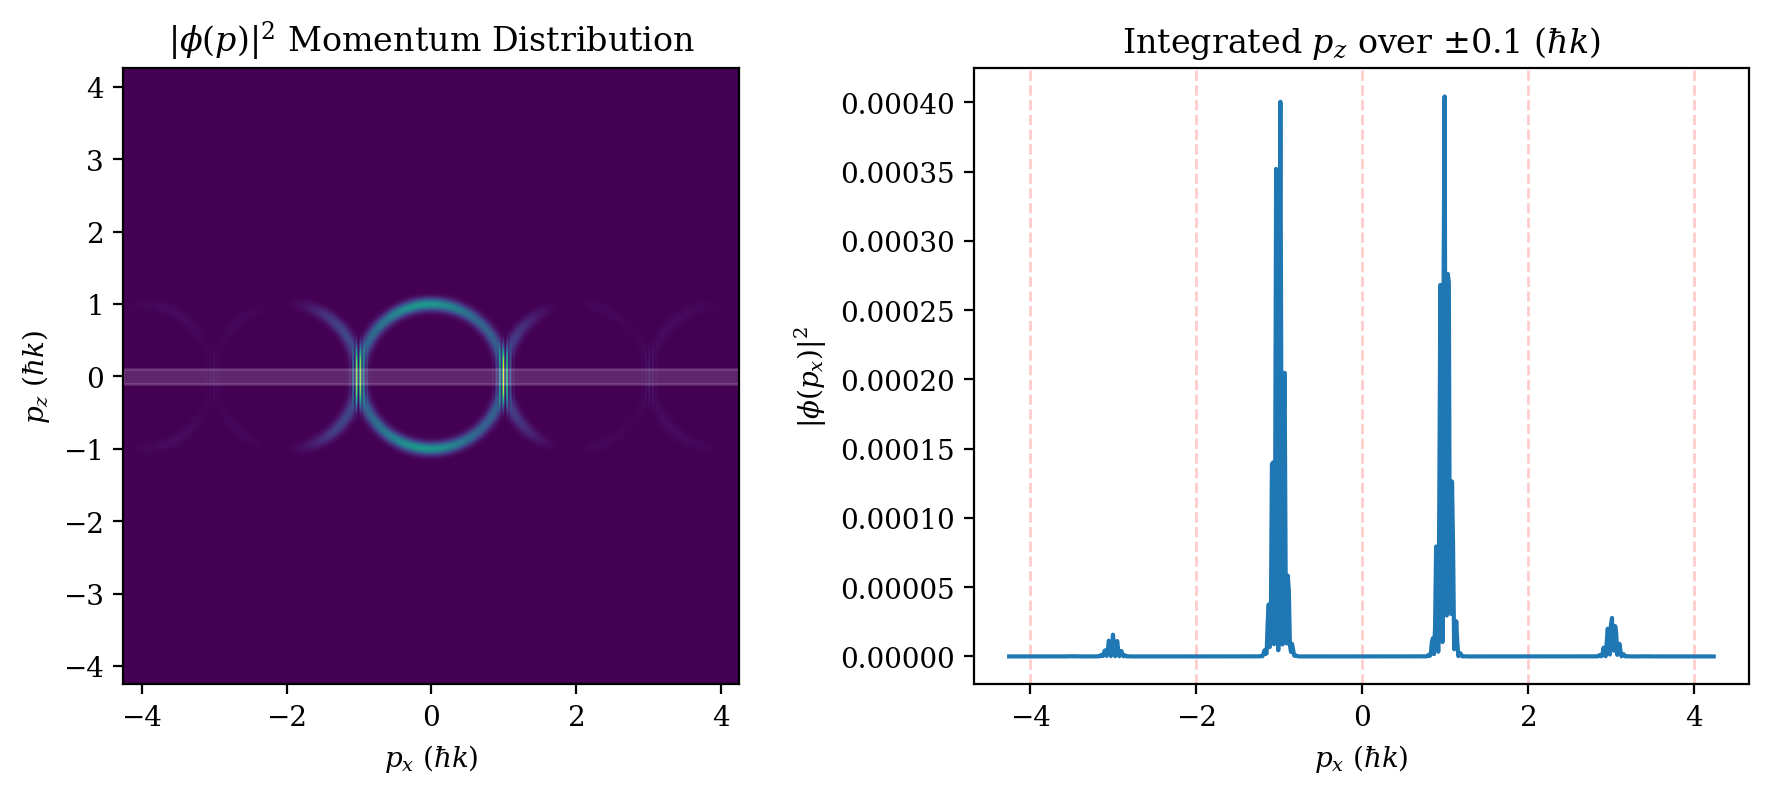

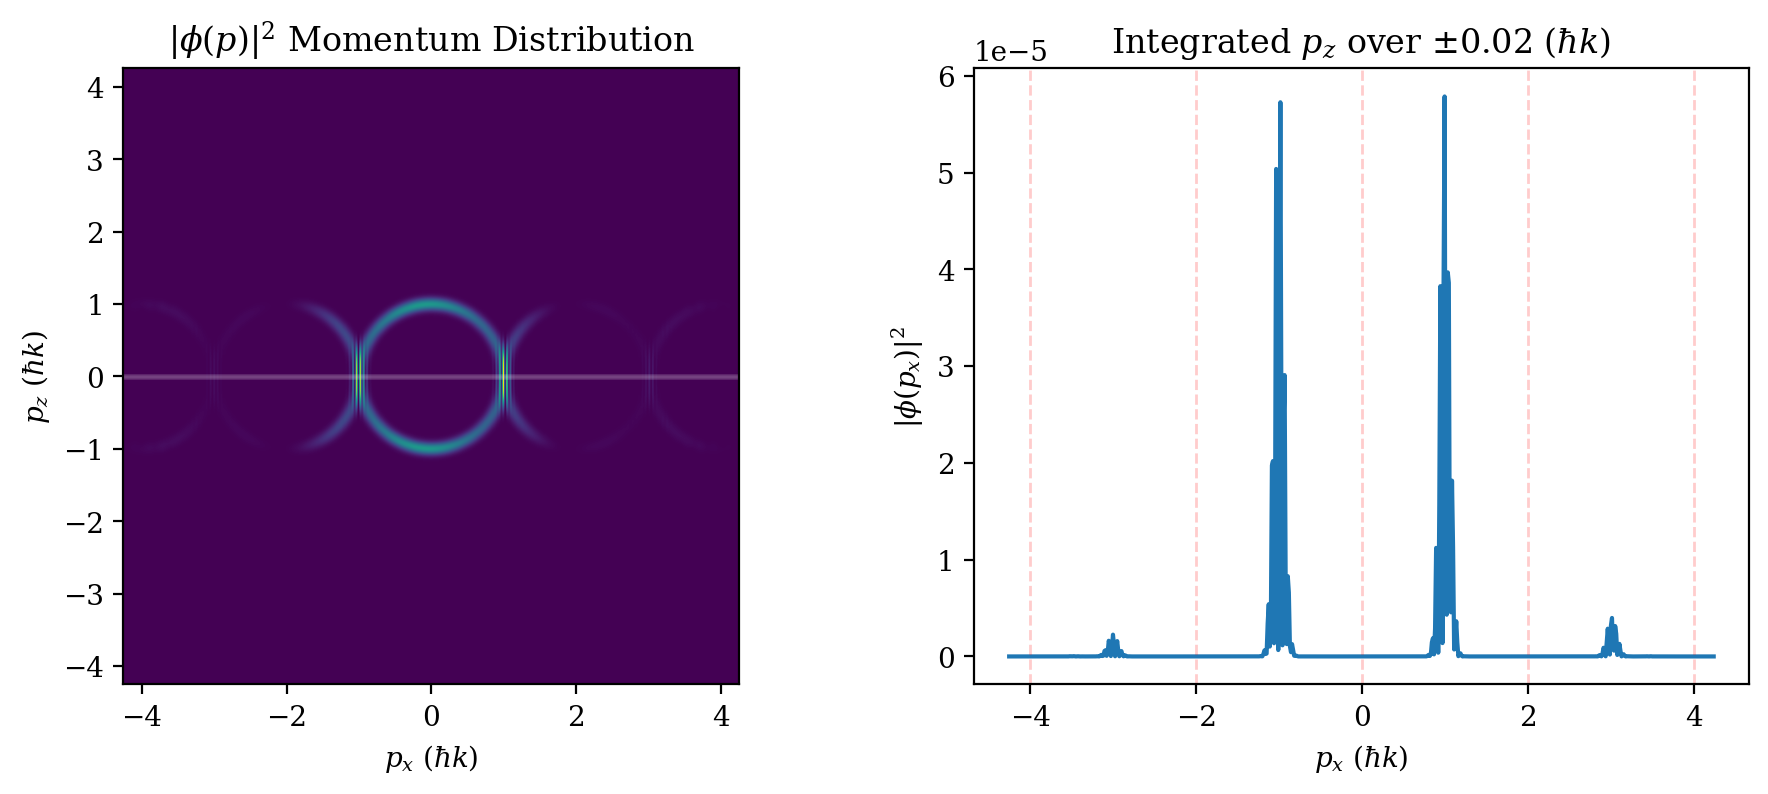

In [147]:
plot_mom_xline(phi,1)
plot_mom_xline(phi,0.5)
plot_mom_xline(phi,0.4)
plot_mom_xline(phi,0.3)
plot_mom_xline(phi,0.2)
plot_mom_xline(phi,0.1)
plot_mom_xline(phi,0.02)